In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
def calculate_metrics(df, successful_counterfactuals_only, calculate_perplexity_score):
    if successful_counterfactuals_only:
        df = df[df["found_flip"] == True]

    if calculate_perplexity_score:
        perplexity_score = df.apply(lambda row: get_perplexity_score(row["counterfactual_perplexity"], row["original_perplexity"]), axis=1)
    else:
        perplexity_score = df["counterfactual_perplexity"].dropna()

    metrics = {
        "label_flip_score": df["found_flip"],
        "sparsity_score": df["levenshtein_similarity_score"],
        "perplexity_score": perplexity_score
    }

    return {key: value for key, value in metrics.items()}

def calculate_confidence_interval_bootstrap(data, metric="mean", confidence=0.95, n_bootstraps=1000, precision=3):
    if metric == "mean":
        statistic_function = np.mean
    elif metric == "median":
        statistic_function = np.median
    else:
        raise ValueError("Metric must be either 'mean' or 'median'")
    
    bootstrapped_statistics = np.array([
        statistic_function(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_bootstraps)
    ])
    
    lower_bound = np.percentile(bootstrapped_statistics, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_statistics, (1 + confidence) / 2 * 100)
    
    h = (upper_bound - lower_bound) / 2
    
    return np.round(h, precision)

def process_csv_files(directory, dataset, dataset_size, successful_counterfactuals_only, median, precision, calculate_perplexity_score):
    data = {
        "method_name": [],
        "label_flip_score": [],
        "sparsity_score": [],
        "perplexity_score": [],
        "label_flip_score_ci": [],
        "sparsity_score_ci": [],
        "perplexity_score_ci": []
    }

    methods = ["HOTFLIP", "CLOSS", "POLYJUICE", "FIZLENAIVE", "FIZLEGUIDED"]

    for method in methods:
        filename = f"{method.lower()}-output-{dataset}-{dataset_size}.csv"
        if filename in os.listdir(directory):
            data["method_name"].append(method)
            df = pd.read_csv(os.path.join(directory, filename))
            metrics = calculate_metrics(df, successful_counterfactuals_only, calculate_perplexity_score)
            for key in ["label_flip_score", "sparsity_score", "perplexity_score"]:
                if key == "perplexity_score" and not calculate_perplexity_score:
                    metric = np.median(metrics[key])
                    metric = int(metric)
                else:
                    metric = np.mean(metrics[key]) if not median else np.median(metrics[key])
                metric = np.round(metric, precision)
                data[key].append(metric)
                statistic = "median" if key == "perplexity_score" else "mean"
                data[f"{key}_ci"].append(calculate_confidence_interval_bootstrap(metrics[key], statistic))

    return data


In [5]:
df = pd.read_csv("../output/closs-output-qnli-100.csv")
median_original_perplexity = np.median(df["original_perplexity"])
print(f"Median original perplexity: {median_original_perplexity}")

Median original perplexity: 79.86995315551758


In [6]:
dataset_size = 1000
output_dir = "../output"

successful_counterfactuals_only = False
precision = 2
median = False
calculate_perplexity_score = False

dataset = "sst_2"
print(f"Dataset: {dataset}:")
data = process_csv_files(output_dir, dataset, dataset_size, successful_counterfactuals_only, median, precision, calculate_perplexity_score)
df_sst = pd.DataFrame(data).set_index("method_name")
display(df_sst)
print("\n" + "="*50 + "\n")

dataset = "qnli"
print(f"Dataset: {dataset}:")
data = process_csv_files(output_dir, dataset, dataset_size, successful_counterfactuals_only, median, precision, calculate_perplexity_score)
df_qnli = pd.DataFrame(data).set_index("method_name")
display(df_qnli)
print("\n" + "="*50 + "\n")


Dataset: sst_2:


,label_flip_score,sparsity_score,perplexity_score,label_flip_score_ci,sparsity_score_ci,perplexity_score_ci
method_name,,,,,,
HOTFLIP,0.63,0.86,653,0.029,0.006,93.873
CLOSS,0.96,0.75,489,0.012,0.011,69.986
POLYJUICE,0.35,0.53,139,0.030,0.018,16.868
FIZLENAIVE,0.88,0.70,277,0.021,0.012,30.764
FIZLEGUIDED,0.85,0.72,312,0.023,0.011,36.777




Dataset: qnli:


,label_flip_score,sparsity_score,perplexity_score,label_flip_score_ci,sparsity_score_ci,perplexity_score_ci
method_name,,,,,,
HOTFLIP,0.88,0.92,132,0.020,0.004,7.184
CLOSS,0.99,0.95,102,0.007,0.003,4.312
POLYJUICE,0.39,0.69,80,0.030,0.011,3.056
FIZLENAIVE,0.42,0.77,69,0.030,0.011,1.994
FIZLEGUIDED,0.26,0.85,80,0.027,0.014,3.673


In [7]:
import pandas as pd

def dataframe_to_latex_table(df_sst, df_qnli):
    methods = df_sst.index
    metrics = ["label_flip_score", "sparsity_score", "perplexity_score"]

     # Determine the best values for each metric in each dataset
    best_values = {}
    for df_name, df in [("sst_2", df_sst), ("qnli", df_qnli)]:
        best_values[df_name] = {}
        for metric in metrics:
            if metric == "label_flip_score" or metric == "sparsity_score":  # Higher is better
                best_values[df_name][metric] = df[metric].max()
            else:  # Lower is better
                best_values[df_name][metric] = df[metric].min()

    # Start the LaTeX table
    latex_table = r"""\begin{table}
    \centering
    \small
    \setlength{\tabcolsep}{5pt}
    \begin{tabular}{|l|ccc|ccc|}
    \hline
    \multirow{2}{*}{\textbf{Method}} & \multicolumn{3}{c|}{\textbf{SST-2}} & \multicolumn{3}{c|}{\textbf{QNLI}} \\
    \cline{2-7}
    & LFS $\uparrow$ & Lev. Sim. $\uparrow$ & Perplexity $\downarrow$ & LFS $\uparrow$ & Lev. Sim. $\uparrow$ & Perplexity $\downarrow$ \\
    \hline
    """

    # Add data rows
    for method in methods:
        row = f"{method} "
        for df_name, df in [("sst_2", df_sst), ("qnli", df_qnli)]:
            for metric in metrics:
                value = df.loc[method, metric]
                if np.isclose(value, best_values[df_name][metric]):
                    row += f"& \\textbf{{{value}}} "
                else:
                    row += f"& {value} "
        row += r"\\"
        latex_table += row + "\n    \\hline\n    "

    # Close the table
    latex_table += r"""\end{tabular}
\end{table}"""

    return latex_table

latex_output = dataframe_to_latex_table(df_sst, df_qnli)
print(latex_output)

\begin{table}
    \centering
    \small
    \setlength{\tabcolsep}{5pt}
    \begin{tabular}{|l|ccc|ccc|}
    \hline
    \multirow{2}{*}{\textbf{Method}} & \multicolumn{3}{c|}{\textbf{SST-2}} & \multicolumn{3}{c|}{\textbf{QNLI}} \\
    \cline{2-7}
    & LFS $\uparrow$ & Lev. Sim. $\uparrow$ & Perplexity $\downarrow$ & LFS $\uparrow$ & Lev. Sim. $\uparrow$ & Perplexity $\downarrow$ \\
    \hline
    HOTFLIP & 0.63 & \textbf{0.86} & 653 & 0.88 & 0.92 & 132 \\
    \hline
    CLOSS & \textbf{0.96} & 0.75 & 489 & \textbf{0.99} & \textbf{0.95} & 102 \\
    \hline
    POLYJUICE & 0.35 & 0.53 & \textbf{139} & 0.39 & 0.69 & 80 \\
    \hline
    FIZLENAIVE & 0.88 & 0.7 & 277 & 0.42 & 0.77 & \textbf{69} \\
    \hline
    FIZLEGUIDED & 0.85 & 0.72 & 312 & 0.26 & 0.85 & 80 \\
    \hline
    \end{tabular}
\end{table}


### Graph the results


In [547]:
df_sst.head()

,label_flip_score,sparsity_score,perplexity_score,label_flip_score_ci,sparsity_score_ci,perplexity_score_ci
method_name,,,,,,
HOTFLIP,0.63,0.86,653,0.030,0.006,94.345
CLOSS,0.96,0.75,489,0.012,0.010,70.927
POLYJUICE,0.35,0.53,139,0.030,0.017,16.401
FIZLENAIVE,0.88,0.70,277,0.020,0.011,30.547
FIZLEGUIDED,0.85,0.72,312,0.021,0.011,38.051


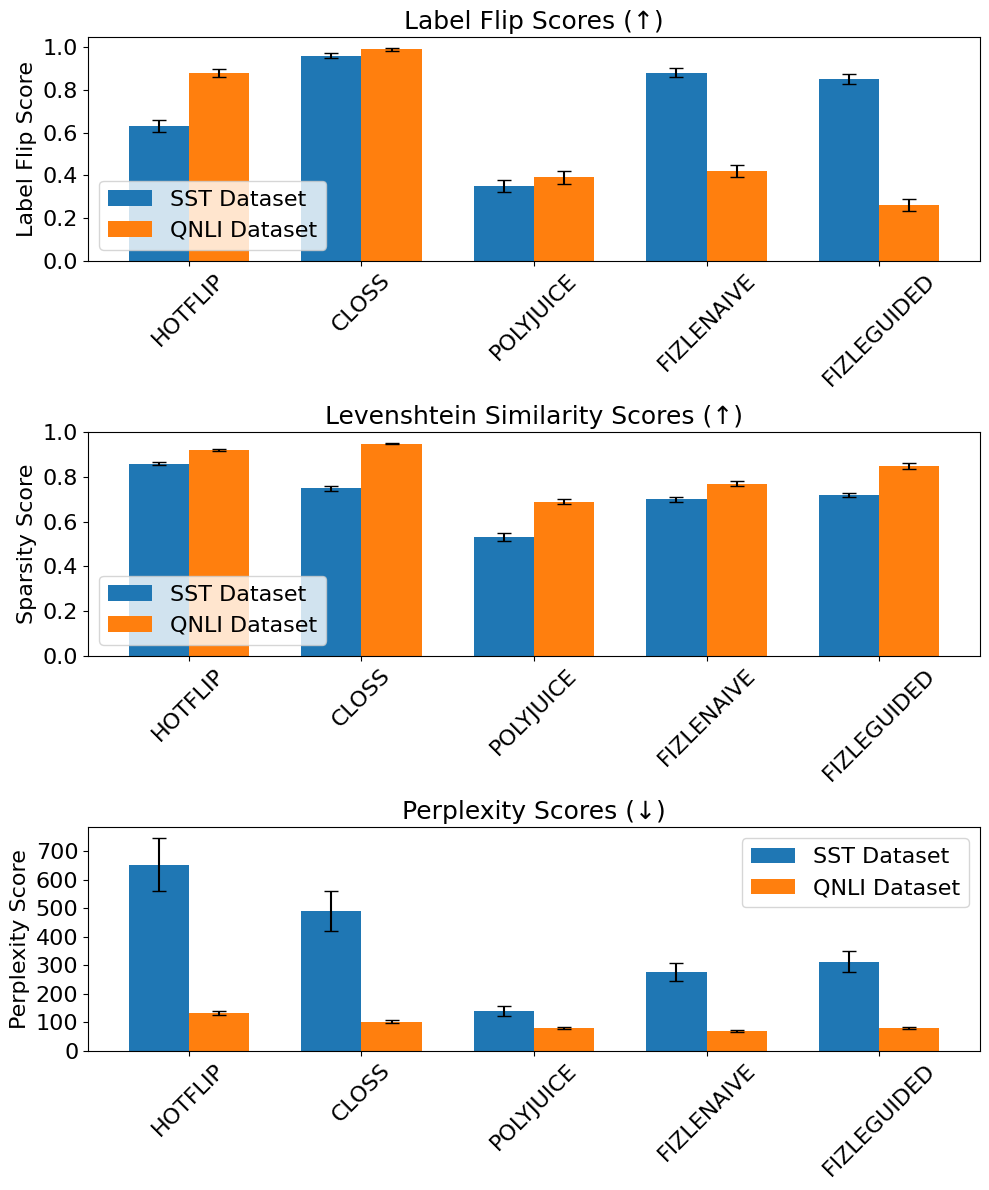

In [11]:
import matplotlib.pyplot as plt
import datetime

# Create subplots for each score type
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Define the width of the bars
width = 0.35  # width of bars
index = df_sst.index
x = range(len(index))

# Set font sizes
plt.rcParams["axes.titlesize"] = 18        # Font size for the title
plt.rcParams["axes.labelsize"] = 16        # Font size for x and y labels
plt.rcParams["xtick.labelsize"] = 16       # Font size for x tick labels
plt.rcParams["ytick.labelsize"] = 16       # Font size for y tick labels
plt.rcParams["legend.fontsize"] = 16       # Font size for legend text

uparrow = "\u2191"
downarrow = "\u2193"

# Plot Label Flip Score comparison
axes[0].bar(x, df_sst["label_flip_score"], width=width, label="SST Dataset", yerr=df_sst["label_flip_score_ci"], capsize=5)
axes[0].bar([p + width for p in x], df_qnli["label_flip_score"], width=width, label="QNLI Dataset", yerr=df_qnli["label_flip_score_ci"], capsize=5)
axes[0].set_title(f"Label Flip Scores ({uparrow})")
axes[0].set_ylabel("Label Flip Score")
axes[0].set_yticks(np.arange(0, 1.2, 0.2))
axes[0].set_xticks([p + width/2 for p in x])
axes[0].set_xticklabels(index, rotation=45)
axes[0].legend()

# Plot Sparsity Score comparison
axes[1].bar(x, df_sst["sparsity_score"], width=width, label="SST Dataset", yerr=df_sst["sparsity_score_ci"], capsize=5)
axes[1].bar([p + width for p in x], df_qnli["sparsity_score"], width=width, label="QNLI Dataset", yerr=df_qnli["sparsity_score_ci"], capsize=5)
axes[1].set_title(f"Levenshtein Similarity Scores ({uparrow})")
axes[1].set_ylabel("Sparsity Score")
axes[1].set_yticks(np.arange(0, 1.2, 0.2))
axes[1].set_xticks([p + width/2 for p in x])
axes[1].set_xticklabels(index, rotation=45)
axes[1].legend()

# Plot Perplexity Score comparison
axes[2].bar(x, df_sst["perplexity_score"], width=width, label="SST Dataset", yerr=df_sst["perplexity_score_ci"], capsize=5)
axes[2].bar([p + width for p in x], df_qnli["perplexity_score"], width=width, label="QNLI Dataset", yerr=df_qnli["perplexity_score_ci"], capsize=5)
axes[2].set_title(f"Perplexity Scores ({downarrow})")
axes[2].set_ylabel("Perplexity Score")
axes[2].set_yticks(np.arange(0, 800, 100))
axes[2].set_xticks([p + width/2 for p in x])
axes[2].set_xticklabels(index, rotation=45)
axes[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
current_date = datetime.date.today().strftime("%Y-%m-%d")
plt.savefig(f"./images/results-{current_date}.png", dpi=300)


In [10]:
%pwd

'/Users/smcaleese/Documents/masters-thesis-code/analysis'